# Total Consumption per Season

In [6]:
import polars as pl
import matplotlib.pyplot as plt
import logging
import math

logging.getLogger('matplotlib.font_manager').disabled = True

clustering_method = 'kMed' # Options: 'kProt', 'kMed'
dataset = "SWW"    # Options: "SWW", "GroupE"
categorical_features = "technical" # "technical" or "sociodemographic"
building_type = 'flat'  # Options: 'flat', 'house'

## Read Dataset for Visualization

In [7]:
result_df=pl.read_csv(f'/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/{dataset}/DATA/Cluster/hourly_avg_clustering_{clustering_method}_{building_type}_{categorical_features}.csv')

In [8]:
# Read the alle_mittelwerte file
alle_mittelwerte_df = pl.read_csv(f"/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/{dataset}/alle_mittelwerte.csv")

result_df = result_df.with_columns(
    pl.col("resident_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("resident_id")
)

alle_mittelwerte_df = alle_mittelwerte_df.with_columns(
    pl.col("file_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("resident_id")
)

result_df = result_df.join(
    alle_mittelwerte_df.select([
        "resident_id",
        "bruttolastgang_kwh_sum",
        "avg_daily_spring",
        "avg_daily_summer",
        "avg_daily_autumn",
        "avg_daily_winter"
    ]),
    on="resident_id",
    how="left"
)
result_df = result_df.select([
    "resident_id",
    "cluster",
    "bruttolastgang_kwh_sum",
    "avg_daily_spring",
    "avg_daily_summer",
    "avg_daily_autumn",
    "avg_daily_winter"
])

cluster_summary = result_df.group_by("cluster").agg([
    pl.count("resident_id").alias("num_households"),
    pl.mean("bruttolastgang_kwh_sum").alias("avg_yearly_consumption [kWh]"),
    pl.mean("avg_daily_spring").alias("Spring [kWh]").round(1),
    pl.mean("avg_daily_summer").alias("Summer [kWh]").round(1),
    pl.mean("avg_daily_autumn").alias("Autumn [kWh]").round(1),
    pl.mean("avg_daily_winter").alias("Winter [kWh]").round(1),
]).sort("cluster")

# Compute overall averages
overall_yearly_avg = result_df["bruttolastgang_kwh_sum"].mean()
overall_day_avg_spring = result_df['avg_daily_spring'].mean()
overall_day_avg_summer = result_df['avg_daily_summer'].mean()
overall_day_avg_autumn = result_df['avg_daily_autumn'].mean()
overall_day_avg_winter = result_df['avg_daily_winter'].mean()

cluster_summary = cluster_summary.with_columns([
    pl.col("cluster").cast(pl.Utf8)
])
summary_row = pl.DataFrame({
    "cluster": ["Average"],
    "num_households": [result_df["resident_id"].n_unique()],
    "avg_yearly_consumption [kWh]": [overall_yearly_avg],
    "Spring [kWh]": [overall_day_avg_spring],
    "Summer [kWh]": [overall_day_avg_summer],
    "Autumn [kWh]": [overall_day_avg_autumn],
    "Winter [kWh]": [overall_day_avg_winter]
})

# Cast to match schema
summary_row = summary_row.with_columns([
    pl.col("cluster").cast(cluster_summary["cluster"].dtype),
    pl.col("num_households").cast(cluster_summary["num_households"].dtype)
])

final_summary = pl.concat([cluster_summary])

print(final_summary)



shape: (4, 7)
┌─────────┬───────────────┬───────────────┬────────┬───────────────┬───────────────┬───────────────┐
│ cluster ┆ num_household ┆ avg_yearly_co ┆ Spring ┆ Summer [kWh]  ┆ Autumn [kWh]  ┆ Winter [kWh]  │
│ ---     ┆ s             ┆ nsumption     ┆ [kWh]  ┆ ---           ┆ ---           ┆ ---           │
│ str     ┆ ---           ┆ [kWh]         ┆ ---    ┆ f64           ┆ f64           ┆ f64           │
│         ┆ u32           ┆ ---           ┆ f64    ┆               ┆               ┆               │
│         ┆               ┆ f64           ┆        ┆               ┆               ┆               │
╞═════════╪═══════════════╪═══════════════╪════════╪═══════════════╪═══════════════╪═══════════════╡
│ 1       ┆ 333           ┆ 2077.183847   ┆ 5.5    ┆ 5.2           ┆ 5.8           ┆ 6.1           │
│ 2       ┆ 313           ┆ 1404.572652   ┆ 3.8    ┆ 3.5           ┆ 3.9           ┆ 4.1           │
│ 3       ┆ 81            ┆ 2011.543      ┆ 5.5    ┆ 4.7           ┆ 5.4     

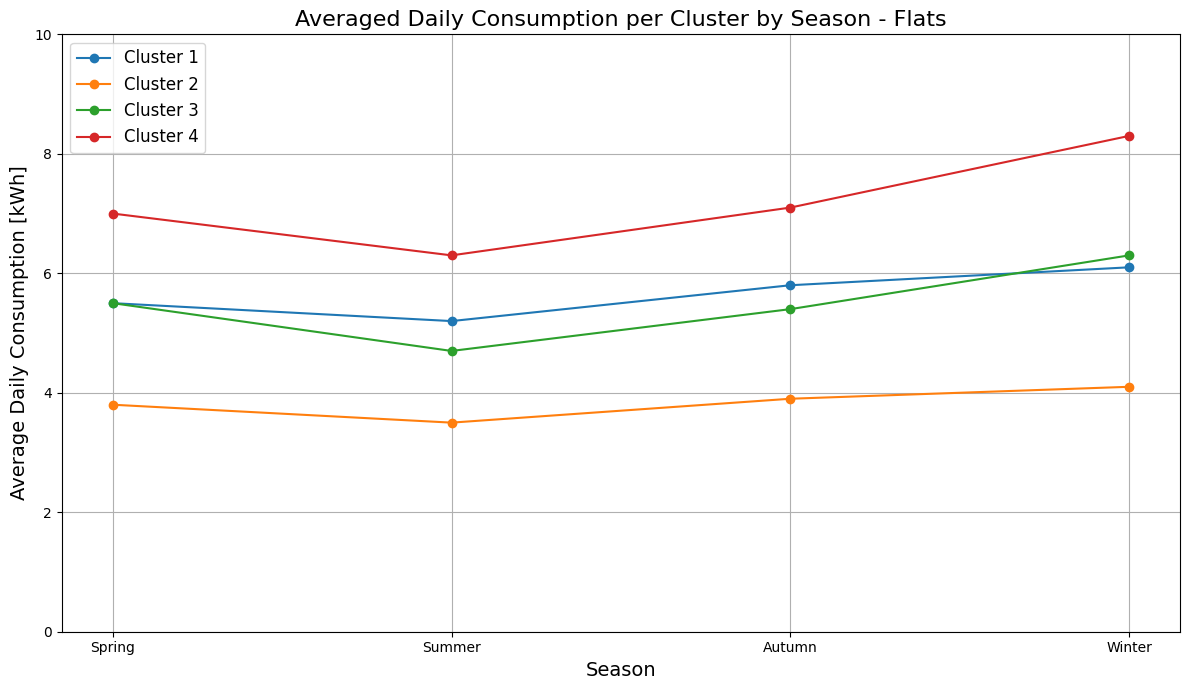

In [9]:
colors= ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b']
linestyles = ['-', '-', '-', '-', '-', '-']
cluster_names = ['HP + PV', 'Non-Electric Heating', 'HP', 'HP + PV + BAT', 'Non-electric Heating + Boiler + PV', 'Non-Electric Heating + Boiler']

seasons = ['Spring', 'Summer', 'Autumn', 'Winter']
clusters = final_summary["cluster"].to_list()

plt.figure(figsize=(12, 7))
i = 0

for cluster in clusters:
    
    # Filter the cluster row
    row = final_summary.filter(pl.col("cluster") == cluster).select([
        "Spring [kWh]", "Summer [kWh]", "Autumn [kWh]", "Winter [kWh]"
    ])
    consumption = row[0, :].to_numpy().flatten().tolist()
    plt.plot(seasons, consumption, marker='o', linestyle = linestyles[i],  label=f"Cluster {cluster}" , color = colors[i])
    i = i+1

plt.xlabel('Season', fontsize=14)
plt.ylabel('Average Daily Consumption [kWh]', fontsize=14)
plt.title(f'Averaged Daily Consumption per Cluster by Season - {building_type.capitalize()}s', fontsize=16)
max_value = final_summary.select(
    pl.max(["Winter [kWh]"])
).max()[0].to_numpy().flatten()[0]

plt.ylim(0, math.ceil((max_value) / 5) * 5)
plt.grid(True)
plt.legend(fontsize='large')
plt.tight_layout()
plt.savefig(
    f'/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/{dataset}/Plots/Cluster/Seasonal_Evolution_{clustering_method}_{building_type}_{categorical_features}.png',
    bbox_inches='tight'
    )
plt.show()


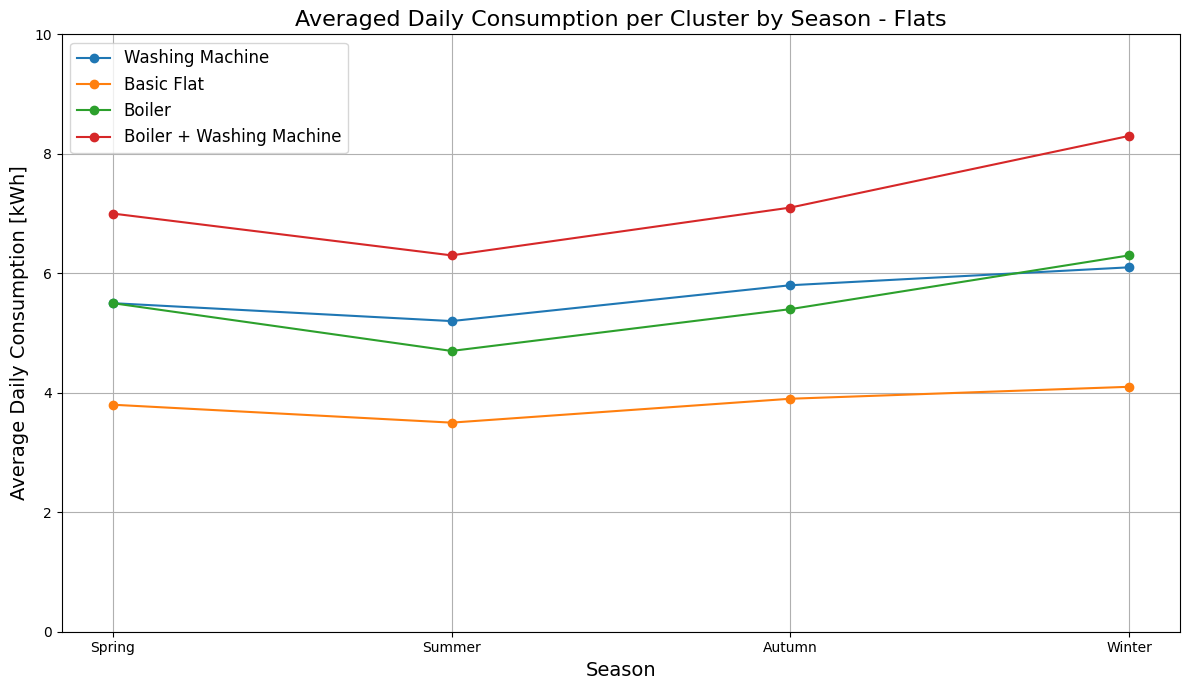

In [10]:
colors= ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b']
linestyles = ['-', '-', '-', '-', '-', '-']
#cluster_names = ['HP + PV', 'Non-Electric Heating', 'HP', 'HP + PV + BAT', 'Non-electric Heating + Boiler + PV', 'Non-Electric Heating + Boiler']
cluster_names = ['Washing Machine', 'Basic Flat', 'Boiler', 'Boiler + Washing Machine']
seasons = ['Spring', 'Summer', 'Autumn', 'Winter']
clusters = final_summary["cluster"].to_list()

plt.figure(figsize=(12, 7))
i = 0

for cluster in clusters:
    
    # Filter the cluster row
    row = final_summary.filter(pl.col("cluster") == cluster).select([
        "Spring [kWh]", "Summer [kWh]", "Autumn [kWh]", "Winter [kWh]"
    ])
    consumption = row[0, :].to_numpy().flatten().tolist()
    plt.plot(seasons, consumption, marker='o', linestyle = linestyles[i],  label=cluster_names[i] , color = colors[i])
    i = i+1

plt.xlabel('Season', fontsize=14)
plt.ylabel('Average Daily Consumption [kWh]', fontsize=14)
plt.title(f'Averaged Daily Consumption per Cluster by Season - {building_type.capitalize()}s', fontsize=16)
max_value = final_summary.select(
    pl.max(["Winter [kWh]"])
).max()[0].to_numpy().flatten()[0]

plt.ylim(0, math.ceil((max_value) / 5) * 5)
plt.grid(True)
plt.legend(fontsize='large')
plt.tight_layout()
plt.savefig(
    f'/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/{dataset}/Plots/Cluster/Seasonal_Evolution_{clustering_method}_{building_type}_{categorical_features}.png',
    bbox_inches='tight'
    )
plt.show()
